### Visualizing the distribution of the observations

### Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12471
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       TMAX|USC00177523|    31|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     2|[00 4F 00 4F 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     6|[20 50 00 00 E0 D...|1976.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     4|[90 D5 E0 D0 00 4...|1977.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     1|[00 C6 00 D3 00 D...|1978.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [19]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00278612')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
#print(rows[0:5])
T=np.vstack(rows)
print(T[0:3])
T=T/10.  # scaling to make the temperature be in centigrade
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     2|[00 4F 00 4F 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     6|[20 50 00 00 E0 D...|1976.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

[[ 28.  28.   0. ..., -17. -39.  -6.]
 [ 33.   0. -39. ..., -83. -50. -78.]
 [-89. -39.  28. ..., -61. -61. -44.]]


(25, 365)

### Script for plotting yearly plots

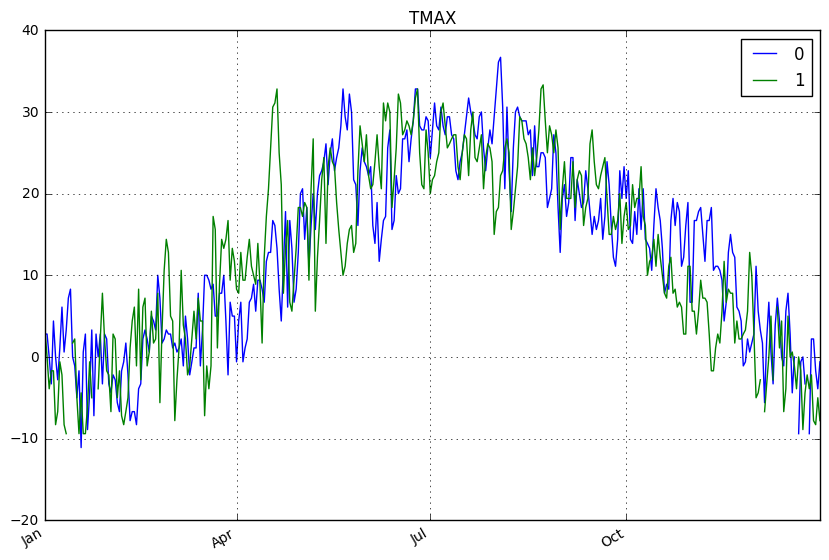

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMAX')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [22]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    
def plot_range(m,fig,axis):
    min_mean=STAT['TMIN']['Mean']/10
    min_f=min_mean*9/5+32
    max_mean=STAT['TMAX']['Mean']/10
    max_f=max_mean*9/5+32
    graphs=np.vstack([min_f,max_f]).transpose()
    YP.plot(graphs,fig,axis,title='TMIN and TMAX')

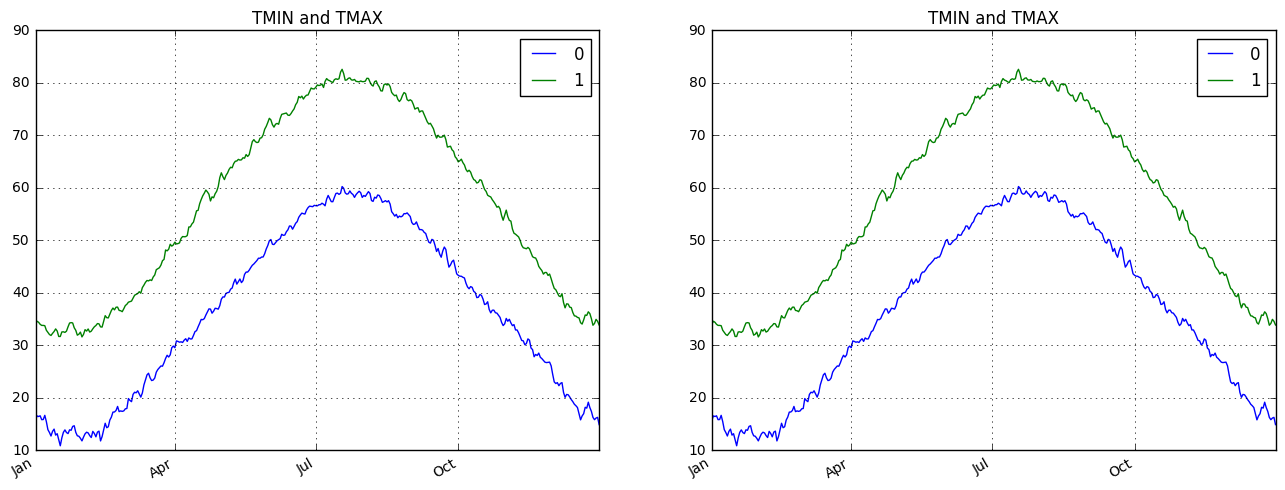

In [23]:
plot_pair(['TMIN','TMIN'],plot_range)

/home/osboxes/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


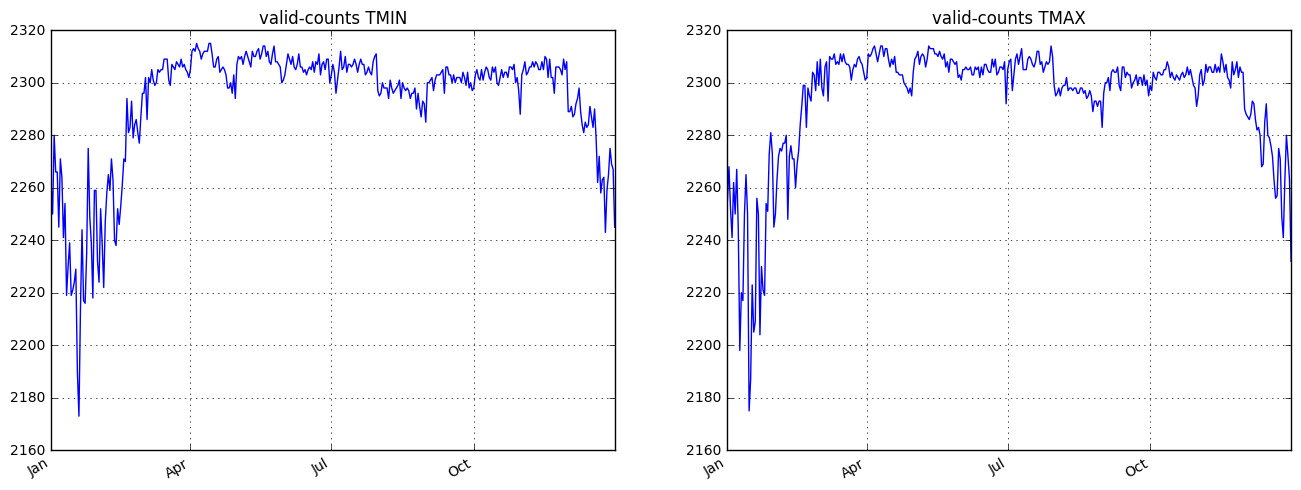

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

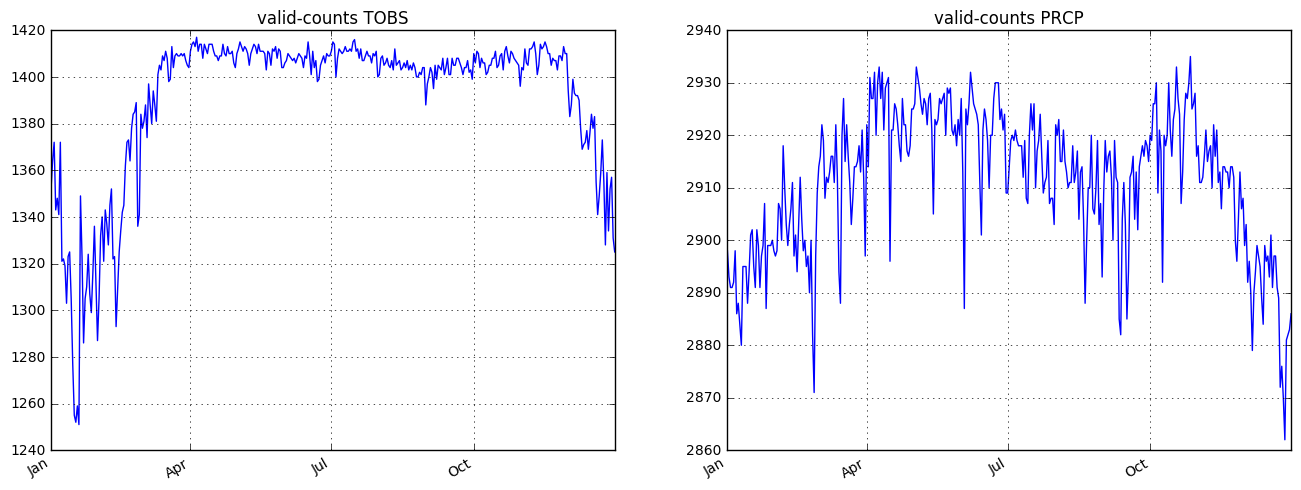

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

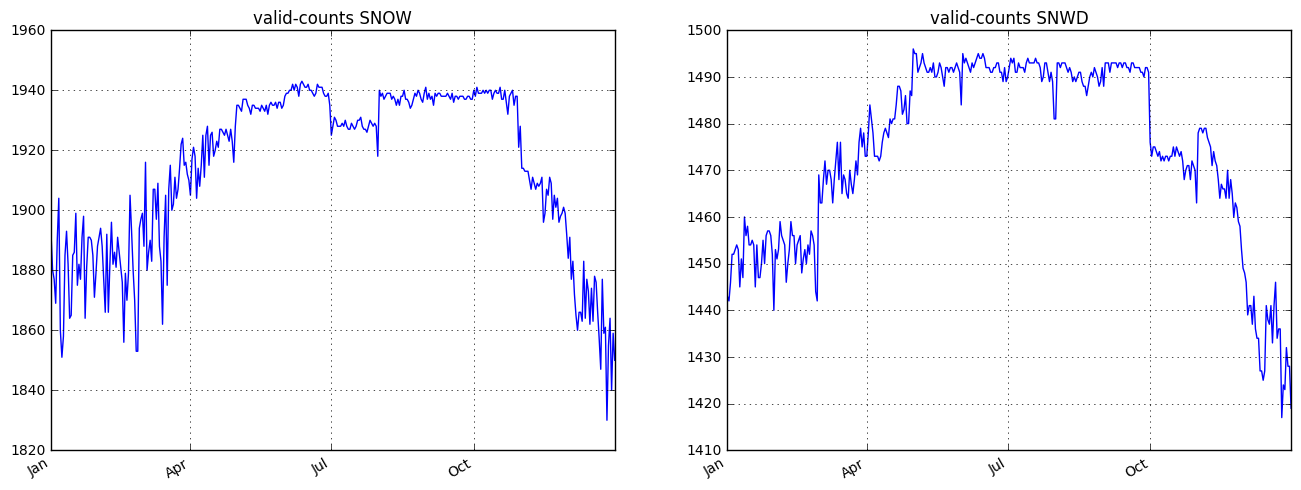

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [30]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

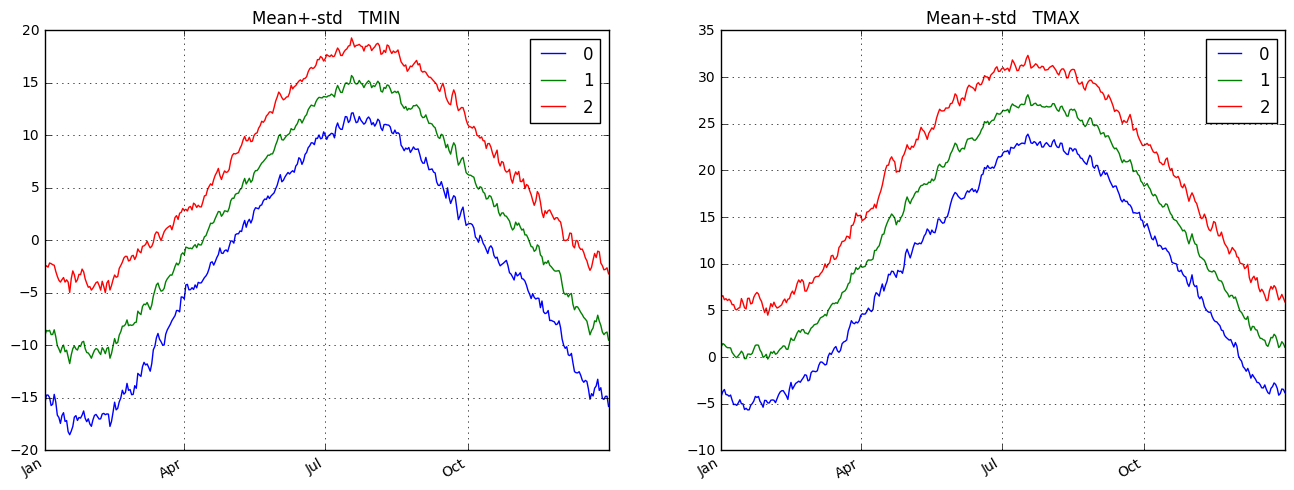

In [29]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

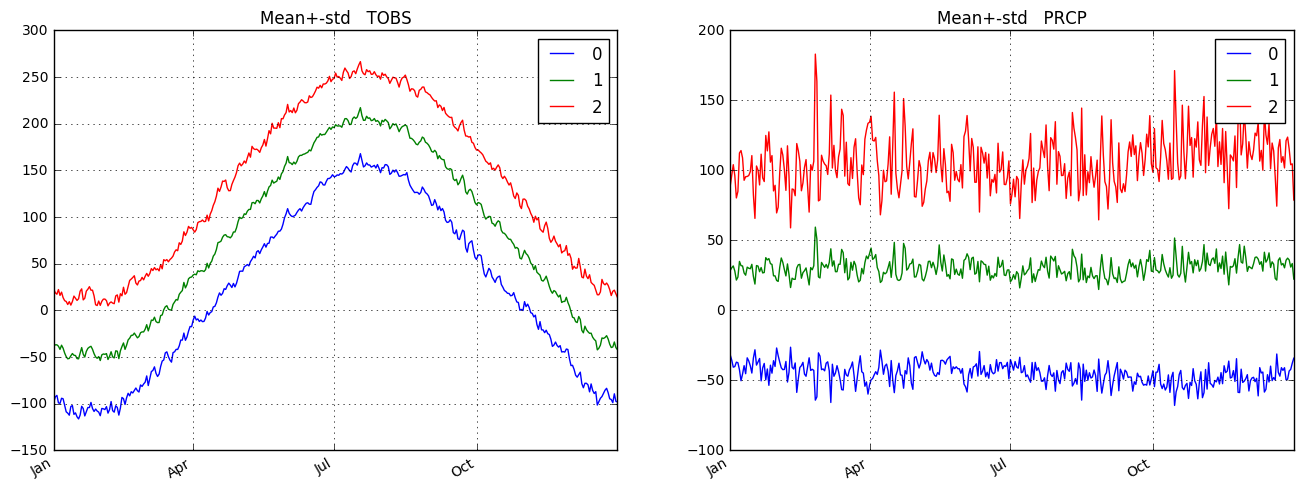

In [31]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

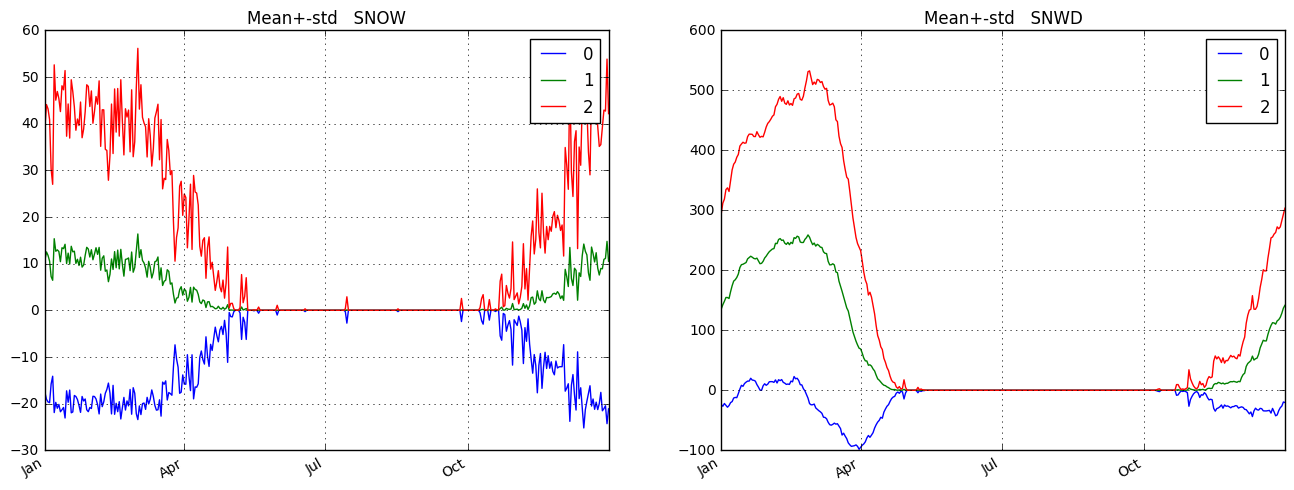

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [19]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

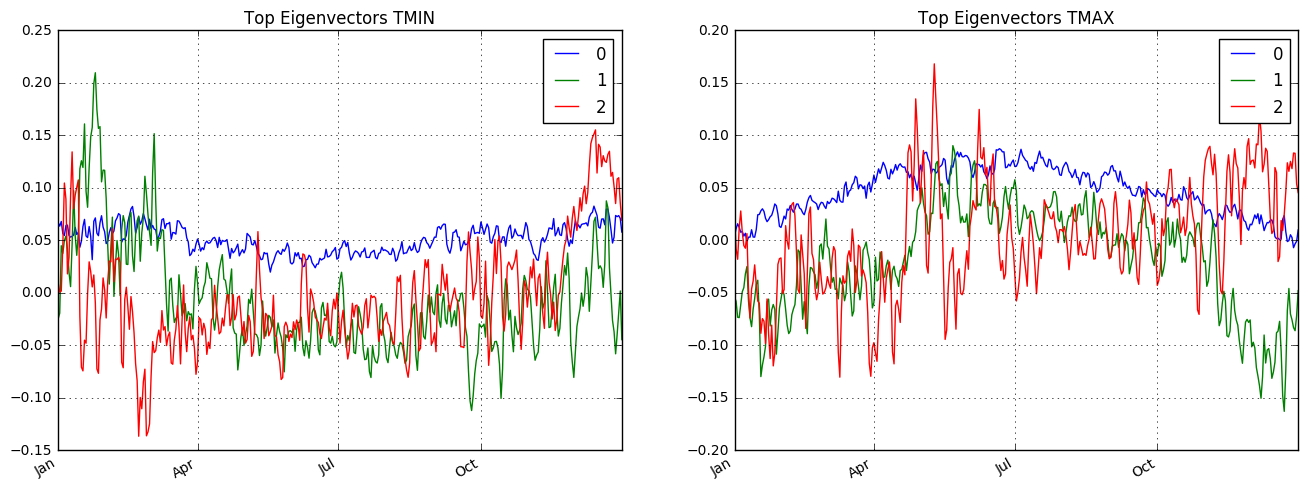

In [20]:
plot_pair(['TMIN','TMAX'],plot_eigen)

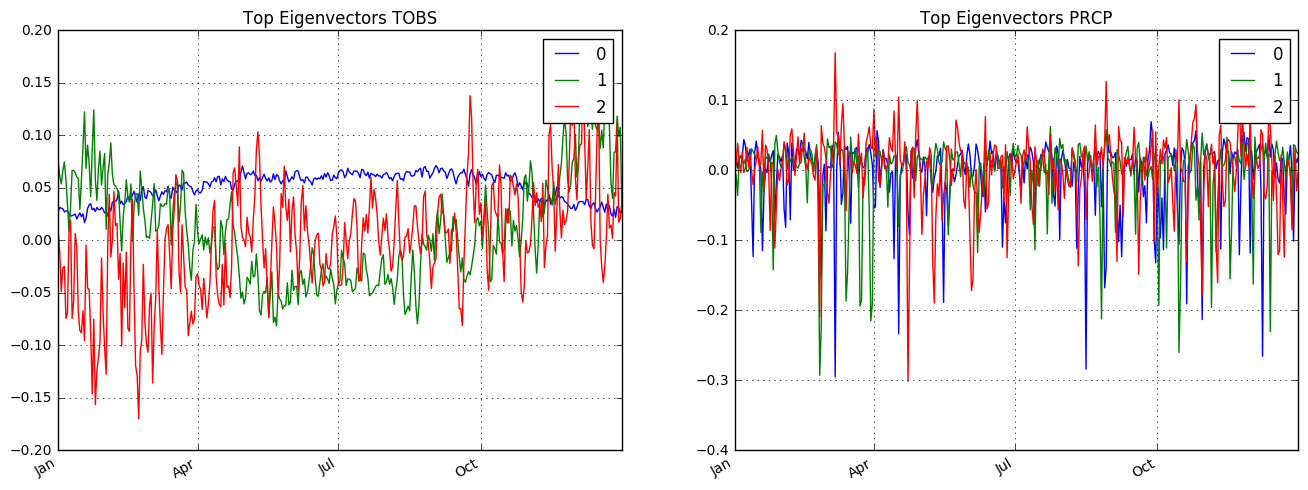

In [21]:
plot_pair(['TOBS','PRCP'],plot_eigen)

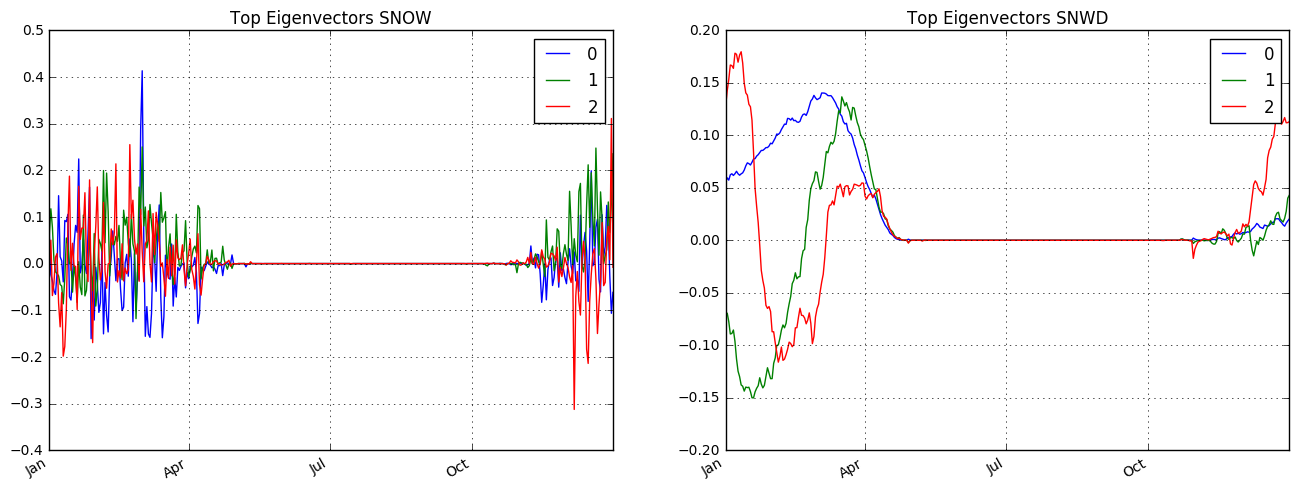

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [23]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

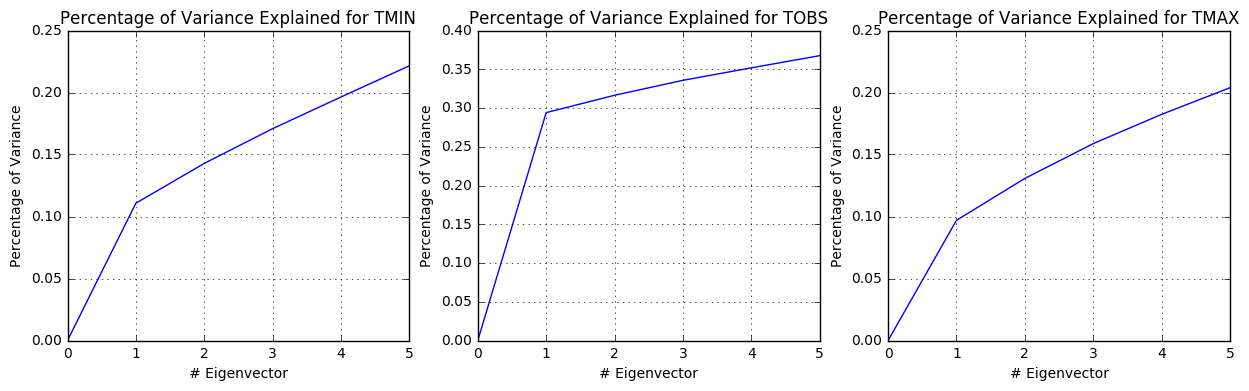

In [24]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

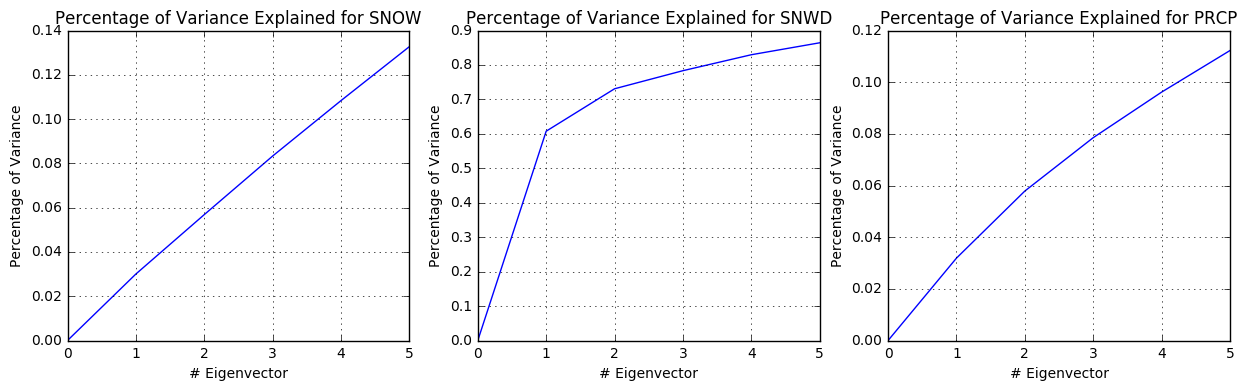

In [25]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()